## Домашнее задание. Строим модели на основе деревьев.

Домашнее задание.
Строим модели на основе деревьев.
Взять два датасета: Первый – Титаник, второй – на ваш выбор.
По каждому датасету:
  Построить модели:
    Decision Tree
    RandomForest
    GradientBosting не менее двух из списка (sklearn, LGBM, CatBoost, xgboost)
  По каждой модели построить метрики:
    Accuracy
    Recall
    Precision
    ROC-AUC + график
Баллы:
3 балла за все 4 модели для первого датасета
3 баллу за все 4 метрики качества для моделей, построенных по первому датасету
2 балла за 4 модели, построенные по второму датасету
2 балла за все 4 мерики для моделей, построенных по первому датасету
Дедлайн: 21 октября 2024 года

## Импорты, функции

In [143]:
# устанавливаем фреймворк catboost
! pip install catboost

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# from sklearn import datasets, svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from sklearn.preprocessing import LabelEncoder    # кодирует категории в числа от 0 до N, где N - число уникальных значений
from sklearn.preprocessing import OrdinalEncoder  # для одновременного колирования нескольких столбцов
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

from catboost import CatBoostClassifier
# from catboost import Pool, CatBoost
from catboost.datasets import titanic


In [145]:
# Функция перевода нечисловых столбцов в числовые или удаление (если количество уникальных значений больше 2)
def get_cleared_df(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
  # получаем числовые столбцы
  numerics_cols = df.columns[df.dtypes != 'object']
  print(f'Колонки с числовыми признаками {numerics_cols}')

  # получаем нечисловые столбцы
  non_numerics_cols = df.columns[df.dtypes == 'object']
  print(f'Колонки с нечисловыми признаками {non_numerics_cols}')

  # обходим все числовые столбцы
  for numeric_column in numerics_cols:
    # меняем все NaN на среднее значение по столбцу
    # вместо
    # df[numeric_column].fillna(df[numeric_column].mean(), inplace=True)
    # df.fillna({numeric_column: df[numeric_column].mean()})
    # применяем
    df[numeric_column] = df[numeric_column].fillna(df[numeric_column].mean())
    # df.method({col: value}, inplace=True)
    # df[col] = df[col].method(value)

  # обходим все нечисловые столбцы
  for non_numeric_column in non_numerics_cols:
    # меняем все NaN на 'Unknown'
    # df[non_numeric_column].fillna('Unknown', inplace=True)
    df[non_numeric_column] = df[non_numeric_column].fillna('Unknown')
    print(f'Нечисловой столбец: {non_numeric_column}, количество уникальных значений: {len(df[non_numeric_column].value_counts())}')
    # если количество уникальных значений в столбце больше двух, то удаляем его из df
    if len(df[non_numeric_column].value_counts()) > 2:
      df = df.drop(columns=[non_numeric_column])
      # или так
      # del df[non_numeric_column]
    else:
      # переводим нечисловые значения в числовые (0 или 1)
      df[non_numeric_column] = df[non_numeric_column].map(lambda x: 0 if x == df[non_numeric_column].unique()[0] else 1)
  return(df)

In [146]:
# Функция кодирования категориальных столбцов
# LabelEncoder и OneHotEncoder. Кодирование меток — это простой и эффективный способ преобразования категориальных переменных в числовую форму.
# Оба кодировщика — часть библиотеки SciKit Learn в Python и оба используются для преобразования категориальных или текстовых данных в числа, которые наши предсказательные модели понимают лучше.
# Для преобразования подобных категорий в понятные модели числовые данные мы и используем класс LabelEncoder. Таким образом, всё что нам нужно сделать, чтобы получить признак для первого столбца, это импортировать класс из библиотеки sklearn, обработать колонку функцией fit_transform и заменить существующие текстовые данные новыми закодированными.
# OneHotEncoder. Этот кодировщик берёт столбец с категориальными данными, который был предварительно закодирован в признак, и создаёт для него несколько новых столбцов. Числа заменяются на единицы и нули, в зависимости от того, какому столбцу какое значение присуще.
# Для одновременного кодирования нескольких столбцов используйте OrdinalEncoder из библиотеки scikit-learn
def get_encoded_df(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
  # получаем числовые столбцы
  numerics_cols = df.columns[df.dtypes != 'object']
  print(f'Колонки с числовыми признаками {numerics_cols}')

  # обходим все числовые столбцы и меняем все NaN на среднее значение по столбцу
  for numeric_column in numerics_cols:
    df[numeric_column] = df[numeric_column].fillna(df[numeric_column].mean())

  # получаем нечисловые столбцы
  non_numerics_cols = df.columns[df.dtypes == 'object']
  print(f'Колонки с нечисловыми признаками {non_numerics_cols}')

  # обходим все нечисловые столбцы и меняем все NaN на 'Unknown'
  for non_numeric_column in non_numerics_cols:
    df[non_numeric_column] = df[non_numeric_column].fillna('Unknown')

  # используем OrdinalEncoder
  encoder = OrdinalEncoder()
  # применяем универсальное кодирование ко всем категориальным столбцам в данных df
  df[non_numerics_cols] = encoder.fit_transform(df[non_numerics_cols])

  return(df)


In [147]:
# Функция вычисления метрик
def get_metrics(model, y_pred, y_test) -> dict:
  # Метрики вычисляются из Confusion Matrix (матрицы ошибок)

  # Accuracy (точность). Количество сделанных правильных прогнозов (TP и TN), разделенное на общее количество сделанных прогнозов.
  # Accuracy = (TP + TN) / (TP + TN + FP + FN)

  # Recall (). Recall = TP / (TP + FN). Показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

  # Precision (прецизионность). Precision = TP / (TP + FP), где TP — количество истинных срабатываний, а FP — количество ложных срабатываний.

  # ROC-AUC + график
  # Он сообщает, какова вероятность того, что случайно выбранный положительный экземпляр будет иметь более высокий рейтинг, чем случайно выбранный отрицательный экземпляр.

  metrics = {
      'model': model.__str__(),
      'accuracy_score' : round(accuracy_score(y_pred, y_test), 2),
      'recall_score' : round(recall_score(y_pred, y_test), 2),
      'precision_score' : round(precision_score(y_pred, y_test), 2),
      'roc_auc_score' : round(roc_auc_score(y_test, y_pred), 2)
  }

  # print(f'Model: {metrics["model"]}')
  # print(f'accuracy_score: {round(accuracy_score(y_pred, y_test), 2)}')
  # print(f'recall_score: {round(recall_score(y_pred, y_test), 2)}')
  # print(f'precision_score: {round(precision_score(y_pred, y_test), 2)}')
  # print(f'roc_auc_score: {round(roc_auc_score(y_test, y_pred), 2)}')

  # график
  # TPR = TP / (TP + FP)
  # FPR = FP / (TP + TN)
  RocCurveDisplay.from_estimator(model, X_test, y_test)
  return(metrics)

In [148]:
# Функция нахождения лучших гиперпараметров для Decision Tree
def get_best_hyperparameters(dtree: DecisionTreeClassifier, X_train, y_train):
  tree_params = {'criterion':['entropy', 'gini'],
               'max_depth':[5, 7, 10, 15],
               'ccp_alpha':[0.01, 0.05, 0.1, 0.5, 1]}
  best_accuracy = 0
  my_random_state = 12345
  for criterion in tree_params['criterion']:
    for max_depth in tree_params['max_depth']:
      for ccp_alpha in tree_params['ccp_alpha']:
        dtree = DecisionTreeClassifier(criterion=criterion,
                                      max_depth=max_depth,
                                      ccp_alpha=ccp_alpha,
                                      random_state=my_random_state,
                                      )
        scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
        avg_accuracy = np.mean(scores)
        if avg_accuracy > best_accuracy:
          best_accuracy = avg_accuracy
          best_params = {'criterion':criterion,
                          'max_depth':max_depth,
                          'ccp_alpha':ccp_alpha}
  return best_params

## 1-й датасет. Титаник.

titanic() - это кортеж длиной 2. titanic()[0] - df (891 строка, 12 колонок), titanic()[1] - df (418 строк, 11 колонок (без survived))

In [149]:
# Решаем задачу классификации. На основании данных о пассажирах Титаника получаем информацию о том, выжил пассажир в катастрофе или нет. Целевой класс имеет два значения: 0 - не выжил, 1 - выжил.

In [150]:
titanic()[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
titanic()[1].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [152]:
titanic()[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [153]:
titanic()[0].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [154]:
# разбиваем датасет на train и test
titanic_train, titanic_test = titanic()

In [155]:
# определяем X (данные о пассажирах) и y (учитель - выжил/нет)
titanic_X, titanic_y = titanic_train.drop('Survived', axis=1), titanic_train.Survived
# удаляем колонки Name и Ticket как неинформативные
titanic_X.drop(['Name', 'Ticket'], axis=1, inplace=True)

## Decision Tree

In [156]:
# Деревья решений (DT) — это непараметрический контролируемый метод обучения, используемый для классификации и регрессии.
# Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной, изучая простые правила принятия решений, выведенные из характеристик данных.
# Дерево можно рассматривать как кусочно-постоянное приближение.
#
# Основная идея алгоритма заключается в построении бинарного дерева, в котором каждый внутренний узел представляет собой условие на признаках,
# а листья — конечный результат работы алгоритма (например, принадлежность к определенному классу).
# Построение дерева происходит по следующему алгоритму:
# 1. Выбирается признак, по которому происходит разделение выборки.
# 2. Выбирается пороговое значение для этого признака.
# 3. Разделяется выборка на две части: объекты, у которых значение признака меньше или равно порогу, и объекты, у которых значение признака больше порога.
# 4. Для каждой из двух полученных подвыборок рекурсивно повторяются шаги 1-3, пока не будет достигнут критерий останова (например, глубина дерева, количество объектов в листе и т.д.).
# 5. В листе дерева выводится ответ — класс или значение целевой переменной.
# Выбор признака для разделения может происходить по различным критериям, например, критерию информативности (Information Gain), Gini impurity или энтропии (Entropy).
# Эти критерии оценивают «чистоту» подвыборок, которые получаются после разделения, и на основании этого выбираются наилучший признак и пороговое значение.

In [157]:
# Очищаем датасет titanic
X = get_cleared_df(titanic_X)
y = titanic_y


Колонки с числовыми признаками Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Колонки с нечисловыми признаками Index(['Sex', 'Cabin', 'Embarked'], dtype='object')
Нечисловой столбец: Sex, количество уникальных значений: 2
Нечисловой столбец: Cabin, количество уникальных значений: 148
Нечисловой столбец: Embarked, количество уникальных значений: 4


In [158]:
# делим на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [159]:
# модель с параметрами по умолчанию
# decision_tree_model = DecisionTreeClassifier()
# Основные параметры класса sklearn.tree.DecisionTreeClassifier
# criterion : {"gini", "entropy", "log_loss"}, default="gini". Функция для измерения качества разделения. Поддерживаемые критерии: «джини» для примеси Джини, а «log_loss» и «энтропия» — для получение информации по Шеннону
# splitter : {"best", "random"}, default="best". Стратегия, используемая для выбора разделения на каждом узле. Поддерживается стратегии «лучшие» для выбора наилучшего разделения и «случайные» для выбора лучшее случайное разделение.
# max_depth, default=None – максимальная глубина дерева
# max_features, default=None — максимальное число признаков, по которым ищется лучшее разбиение в дереве
#   (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков)
# min_samples_leaf, default=1  – минимальное число объектов в листе.
#   У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов

decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=3)
# decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=5)
# decision_tree_model = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=5)

# обучаем модель
# Как и в случае с другими классификаторами, DecisionTreeClassifier принимает в качестве входных данных два массива: массив X, разреженный или плотный, формы (n_samples, n_features),
# содержащий обучающие образцы, и массив Y целочисленных значений, формы (n_samples,), содержащий метки классов для обучающих образцов.
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)

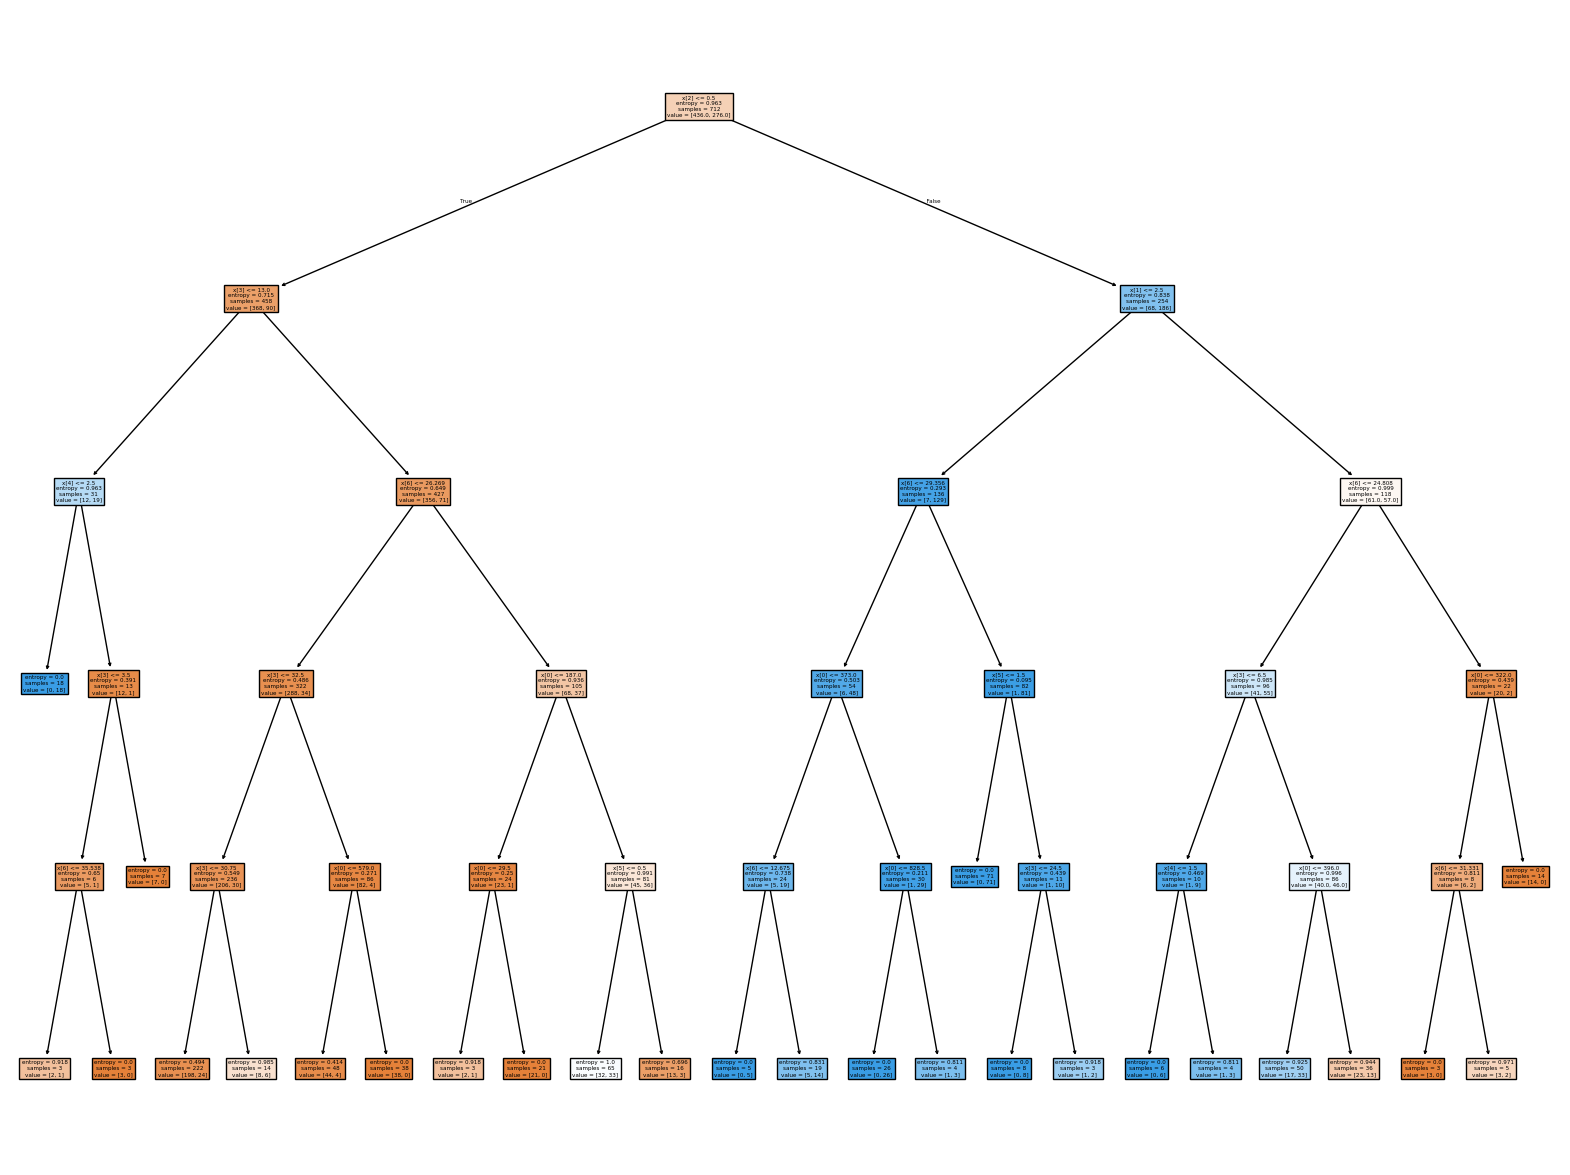

In [160]:
# график Decision Tree
plt.figure(figsize=(20, 15))
# строим дерево
_ = plot_tree(decision_tree_model, filled=True)

### Метрики

In [161]:
decision_tree_model.score(X_test, y_test)

0.7821229050279329

{'model': "DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)", 'accuracy_score': 0.78, 'recall_score': 0.7, 'precision_score': 0.71, 'roc_auc_score': 0.77}


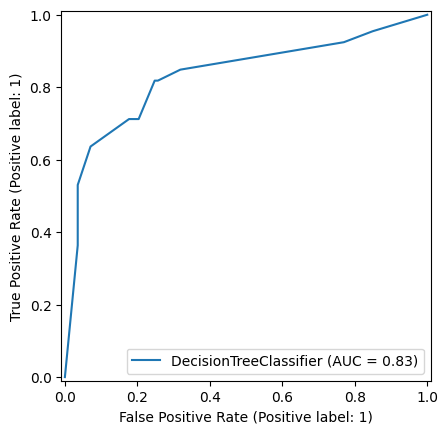

In [162]:
# Прогноз на X_test
decision_tree_model_metrics = get_metrics(model=decision_tree_model, y_pred=decision_tree_model.predict(X_test), y_test=y_test)
# decision_tree_model_metrics['idx'] = [0]
print(decision_tree_model_metrics)
df_sum_metrics_titanic = pd.DataFrame([decision_tree_model_metrics])

In [163]:
df_sum_metrics_titanic

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.78,0.7,0.71,0.77


## Random Forest

In [164]:
# Очищаем датасет titanic
X = get_cleared_df(titanic_X)
y = titanic_y


Колонки с числовыми признаками Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Колонки с нечисловыми признаками Index(['Cabin', 'Embarked'], dtype='object')
Нечисловой столбец: Cabin, количество уникальных значений: 148
Нечисловой столбец: Embarked, количество уникальных значений: 4


In [165]:
# делим на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [166]:
# создаём модель Random Forest
# параметры
# n_estimators -число деревьев. Чем больше деревьев, тем лучше качество. Стоит отметить, что время настройки и работы Random Forest будут пропорционально увеличиваться, что может сказаться на производительности.
# criterion - критерий расщепления. В библиотеке sklearn для задач классификации реализованы критерии gini и entropy. Они соответствуют классическим критериям расщепления: джини и энтропии.
# max_features - число признаков для выбора расщепления. При увеличении max_features увеличивается время построения леса, а деревья становятся похожими друг на друга. В задачах классификации он по умолчанию равен sqrt(n), в задачах регрессии – n/3.
# max_depth - максимальная глубина деревьев. Чем меньше максимальная глубина, тем быстрее строится и работает алгоритм случайного дерева.

random_forest_model = RandomForestClassifier(n_estimators=100)
# обучаем модель
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

### Метрики

In [167]:
random_forest_model.score(X_test, y_test)

0.8044692737430168

{'model': 'RandomForestClassifier()', 'accuracy_score': 0.8, 'recall_score': 0.79, 'precision_score': 0.66, 'roc_auc_score': 0.78}


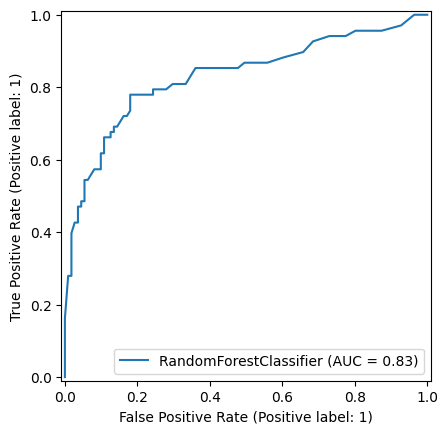

In [168]:
# Прогноз на X_test
random_forest_model_metrics = get_metrics(model=random_forest_model, y_pred=random_forest_model.predict(X_test), y_test=y_test)
print(random_forest_model_metrics)
df_sum_metrics_titanic = pd.concat([df_sum_metrics_titanic, pd.DataFrame([random_forest_model_metrics])], ignore_index=True)

In [169]:
df_sum_metrics_titanic

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.78,0.70,0.71,0.77
1,RandomForestClassifier(),0.80,0.79,0.66,0.78


## Gradient Boosting (CatBoost)

In [170]:
# Градиентный бустинг – это продвинутый алгоритм машинного обучения для решения задач классификации и регрессии.
# Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений. Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную.
# Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом, что каждая последующая модель сводит ошибку предыдущей к минимуму.
# Параметры алгоритма:
# loss – функция ошибки для минимизации.
# criterion – критерий выбора расщепления, Mean Absolute Error (MAE) или Mean Squared Error (MSE). Используется только при построении деревьев.
# init – какой алгоритм мы будем использовать в качестве главного (именно его и улучшает техника бустинга).
# learning_rate – скорость обучения.
# n_estimators – число итераций в бустинге. Чем больше, тем лучше качество, однако слишком большой увеличение данного параметра может привести к ухудшению производительности и переобучению.
# min_samples_split – минимальное число объектов, при котором происходит расщепление. С данным параметром мы можем избежать переобучение.
# min_samples_leaf – минимальное число объектов в листе (узле). При увеличении данного параметра качество модели на обучении падает, в то время как время построения модели сокращается. Меньшие значения стоит выбирать для менее сбалансированных выборок.
# max_depth – максимальная глубина дерева. Используется для того, чтобы исключить возможность переобучения.
# max_features – количество признаков, учитываемых алгоритмом для построения расщепления в дереве.
# max_leaf_nodes : Максимальное число верхних точек в дереве. При наличии данного параметра max_depth будет игнорироваться.

In [171]:
# Очищаем датасет titanic
X = get_cleared_df(titanic_X)
y = titanic_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Колонки с числовыми признаками Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Колонки с нечисловыми признаками Index(['Cabin', 'Embarked'], dtype='object')
Нечисловой столбец: Cabin, количество уникальных значений: 148
Нечисловой столбец: Embarked, количество уникальных значений: 4


In [172]:
# создаём модель
gradient_boosting_catBoost_model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1)
# обучаем модель
gradient_boosting_catBoost_model.fit(X_train, y_train, silent=True)

### Метрики

In [173]:
gradient_boosting_catBoost_model.score(X_test, y_test)

0.7877094972067039

{'model': '<catboost.core.CatBoostClassifier object at 0x7de34982d780>', 'accuracy_score': 0.79, 'recall_score': 0.78, 'precision_score': 0.64, 'roc_auc_score': 0.76}


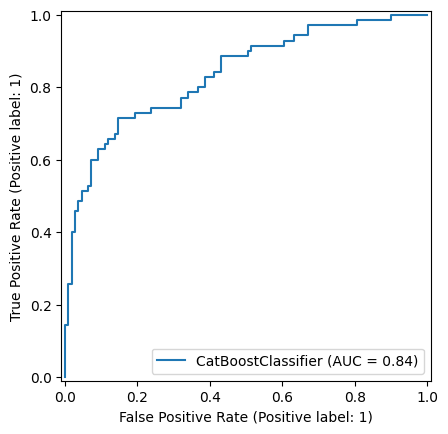

In [174]:
# Прогноз на X_test
gradient_boosting_catBoost_model_metrics = get_metrics(model=gradient_boosting_catBoost_model, y_pred=gradient_boosting_catBoost_model.predict(X_test), y_test=y_test)
print(gradient_boosting_catBoost_model_metrics)
df_sum_metrics_titanic = pd.concat([df_sum_metrics_titanic, pd.DataFrame([gradient_boosting_catBoost_model_metrics])], ignore_index=True)

In [175]:
df_sum_metrics_titanic

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.78,0.70,0.71,0.77
1,RandomForestClassifier(),0.80,0.79,0.66,0.78
2,<catboost.core.CatBoostClassifier object at 0x...,0.79,0.78,0.64,0.76


## Gradient Boosting (LightGBM)

In [176]:
# Очищаем датасет titanic
X = get_cleared_df(titanic_X)
y = titanic_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

Колонки с числовыми признаками Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
Колонки с нечисловыми признаками Index(['Cabin', 'Embarked'], dtype='object')
Нечисловой столбец: Cabin, количество уникальных значений: 148
Нечисловой столбец: Embarked, количество уникальных значений: 4


In [177]:
# создаём модель
# CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1)
gradient_boosting_LightGBM_model = lgb.LGBMClassifier(max_depth=3)
# обучаем модель
gradient_boosting_LightGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 276, number of negative: 436
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.387640 -> initscore=-0.457241
[LightGBM] [Info] Start training from score -0.457241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(max_depth=3)

### Метрики

In [178]:
gradient_boosting_LightGBM_model.score(X_test, y_test)

0.8156424581005587

{'model': 'LGBMClassifier(max_depth=3)', 'accuracy_score': 0.82, 'recall_score': 0.8, 'precision_score': 0.67, 'roc_auc_score': 0.78}


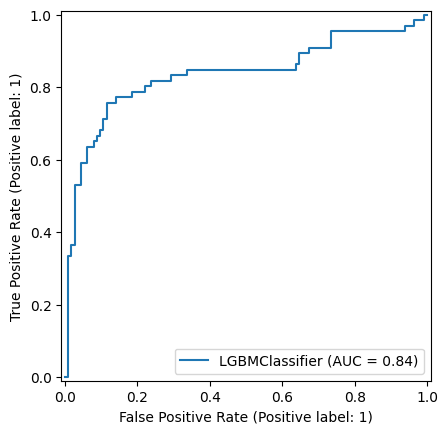

In [179]:
# Прогноз на X_test
gradient_boosting_LightGBM_model_metrics = get_metrics(model=gradient_boosting_LightGBM_model, y_pred=gradient_boosting_LightGBM_model.predict(X_test), y_test=y_test)
print(gradient_boosting_LightGBM_model_metrics)
df_sum_metrics_titanic = pd.concat([df_sum_metrics_titanic, pd.DataFrame([gradient_boosting_LightGBM_model_metrics])], ignore_index=True)


## Метрики Titanic

In [180]:
df_sum_metrics_titanic

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.78,0.70,0.71,0.77
1,RandomForestClassifier(),0.80,0.79,0.66,0.78
2,<catboost.core.CatBoostClassifier object at 0x...,0.79,0.78,0.64,0.76
3,LGBMClassifier(max_depth=3),0.82,0.80,0.67,0.78


## 2-й датасет. Heart Attack Analysis & Prediction Dataset (получен с https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [181]:
# Attribute Information
# Age: age of the patient [years]
# Sex: sex of the patient [M: Male, F: Female]
# ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
# RestingBP: resting blood pressure [mm Hg]
# Cholesterol: serum cholesterol [mm/dl]
# FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
# RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
# MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
# ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
# Oldpeak: oldpeak = ST [Numeric value measured in depression]
# ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
# HeartDisease: output class [1: heart disease, 0: Normal]
# Решаем задачу классификации. На основании данных об анализах пациента получаем информацию о сердечных заболеваниях пациента. Целевой класс имеет два значения: 1 - есть сердечное заболевание, 0 - норма.

In [182]:
heart = pd.read_csv('heart.csv')

In [183]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [184]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [185]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [186]:
# кодируем категориальные столбцы
heart = get_encoded_df(heart)

Колонки с числовыми признаками Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')
Колонки с нечисловыми признаками Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [187]:
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1.0,1.0,140,289,0,1.0,172,0.0,0.0,2.0,0
1,49,0.0,2.0,160,180,0,1.0,156,0.0,1.0,1.0,1
2,37,1.0,1.0,130,283,0,2.0,98,0.0,0.0,2.0,0
3,48,0.0,0.0,138,214,0,1.0,108,1.0,1.5,1.0,1
4,54,1.0,2.0,150,195,0,1.0,122,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1.0,3.0,110,264,0,1.0,132,0.0,1.2,1.0,1
914,68,1.0,0.0,144,193,1,1.0,141,0.0,3.4,1.0,1
915,57,1.0,0.0,130,131,0,1.0,115,1.0,1.2,1.0,1
916,57,0.0,1.0,130,236,0,0.0,174,0.0,0.0,1.0,1


In [188]:
# определяем X (данные анализов пациентов) и y (учитель - есть заболевание/нет заболевания)
heart_X, heart_y = heart.drop('HeartDisease', axis=1), heart.HeartDisease

## Decision Tree

In [189]:
#
X = heart_X
y = heart_y

In [190]:
# делим на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [191]:
decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=3)
# decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=5)
# decision_tree_model = DecisionTreeClassifier(criterion="gini", max_depth=5, min_samples_leaf=5)

# обучаем модель
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)

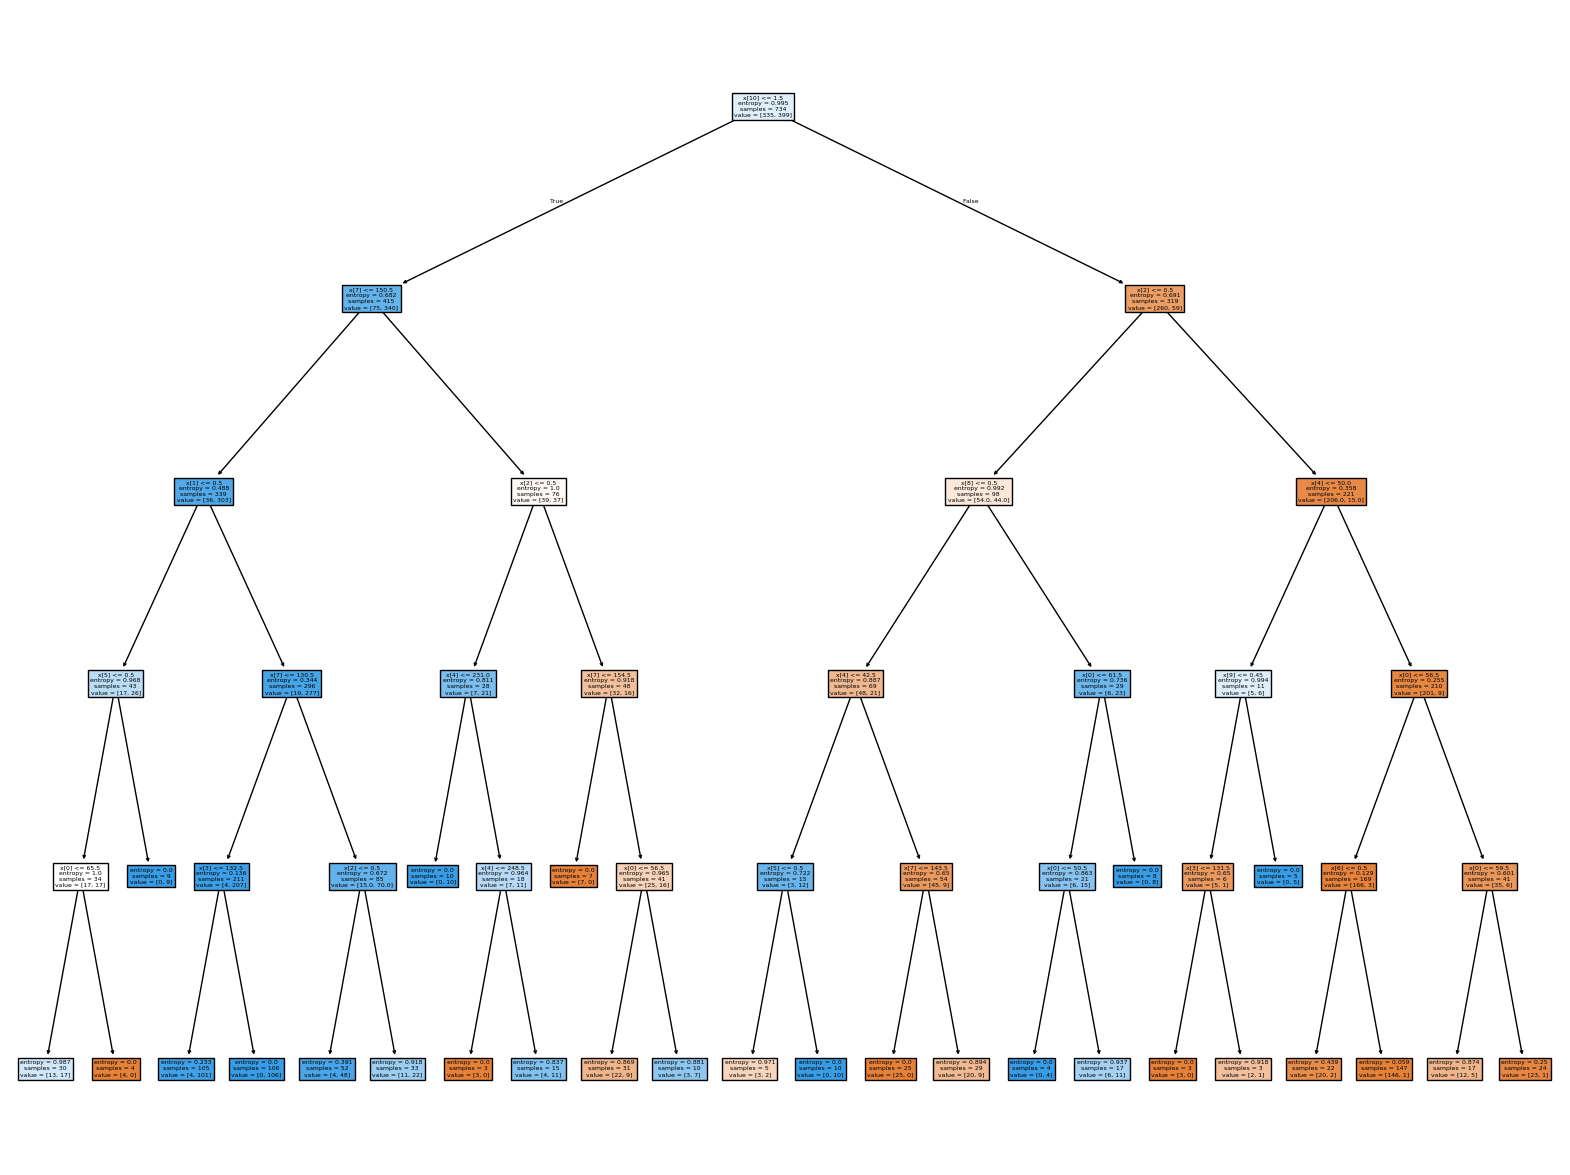

In [192]:
# график Decision Tree
plt.figure(figsize=(20, 15))
# строим дерево
_ = plot_tree(decision_tree_model, filled=True)

### Метрики

In [193]:
decision_tree_model.score(X_test, y_test)

0.8152173913043478

{'model': "DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=3)", 'accuracy_score': 0.82, 'recall_score': 0.82, 'precision_score': 0.89, 'roc_auc_score': 0.8}


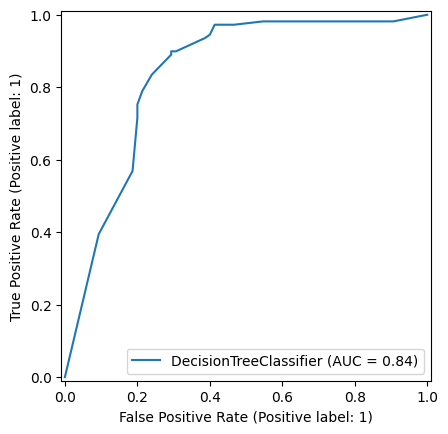

In [194]:
# Прогноз на X_test
decision_tree_model_metrics = get_metrics(model=decision_tree_model, y_pred=decision_tree_model.predict(X_test), y_test=y_test)
print(decision_tree_model_metrics)
df_sum_metrics_heart = pd.DataFrame([decision_tree_model_metrics])

In [195]:
df_sum_metrics_heart

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.82,0.82,0.89,0.8


## Random Forest

In [196]:
#
X = heart_X
y = heart_y

In [197]:
# делим на test и train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [198]:
# создаём модель Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100)
# обучаем модель
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

### Метрики

In [199]:
random_forest_model.score(X_test, y_test)

0.8532608695652174

{'model': 'RandomForestClassifier()', 'accuracy_score': 0.85, 'recall_score': 0.85, 'precision_score': 0.93, 'roc_auc_score': 0.83}


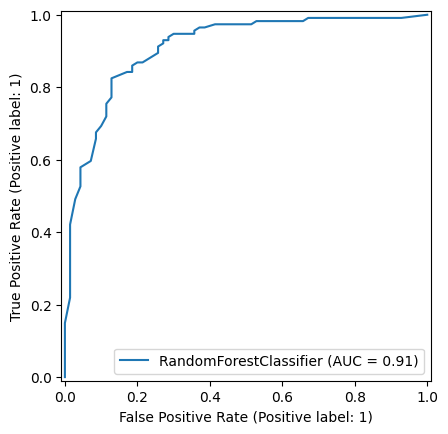

In [200]:
# Прогноз на X_test
random_forest_model_metrics = get_metrics(model=random_forest_model, y_pred=random_forest_model.predict(X_test), y_test=y_test)
print(random_forest_model_metrics)
df_sum_metrics_heart = pd.concat([df_sum_metrics_heart, pd.DataFrame([random_forest_model_metrics])], ignore_index=True)

In [201]:
df_sum_metrics_heart

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.82,0.82,0.89,0.80
1,RandomForestClassifier(),0.85,0.85,0.93,0.83


## Gradient Boosting (CatBoost)

In [202]:
#
X = heart_X
y = heart_y

# Делимм на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [203]:
# создаём модель
gradient_boosting_catBoost_model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1)
# обучаем модель
gradient_boosting_catBoost_model.fit(X_train, y_train, silent=True)

### Метрики

In [204]:
gradient_boosting_catBoost_model.score(X_test, y_test)

0.8804347826086957

{'model': '<catboost.core.CatBoostClassifier object at 0x7de34bd4c040>', 'accuracy_score': 0.88, 'recall_score': 0.88, 'precision_score': 0.92, 'roc_auc_score': 0.87}


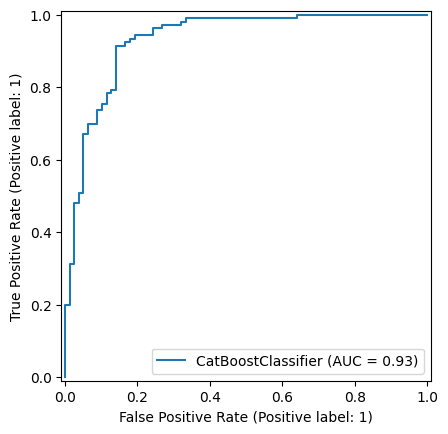

In [205]:
# Прогноз на X_test
gradient_boosting_catBoost_model_metrics = get_metrics(model=gradient_boosting_catBoost_model, y_pred=gradient_boosting_catBoost_model.predict(X_test), y_test=y_test)
print(gradient_boosting_catBoost_model_metrics)
df_sum_metrics_heart = pd.concat([df_sum_metrics_heart, pd.DataFrame([gradient_boosting_catBoost_model_metrics])], ignore_index=True)

In [206]:
df_sum_metrics_heart

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.82,0.82,0.89,0.80
1,RandomForestClassifier(),0.85,0.85,0.93,0.83
2,<catboost.core.CatBoostClassifier object at 0x...,0.88,0.88,0.92,0.87


## Gradient Boosting (LightGBM)

In [207]:
#
X = heart_X
y = heart_y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [224]:
# создаём модель
gradient_boosting_LightGBM_model = lgb.LGBMClassifier(n_estimators=70, max_depth=2)
# обучаем модель
gradient_boosting_LightGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 416, number of negative: 318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566757 -> initscore=0.268634
[LightGBM] [Info] Start training from score 0.268634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(max_depth=2, n_estimators=70)

### Метрики

In [225]:
gradient_boosting_LightGBM_model.score(X_test, y_test)

0.8532608695652174

{'model': 'LGBMClassifier(max_depth=2, n_estimators=70)', 'accuracy_score': 0.85, 'recall_score': 0.84, 'precision_score': 0.87, 'roc_auc_score': 0.85}


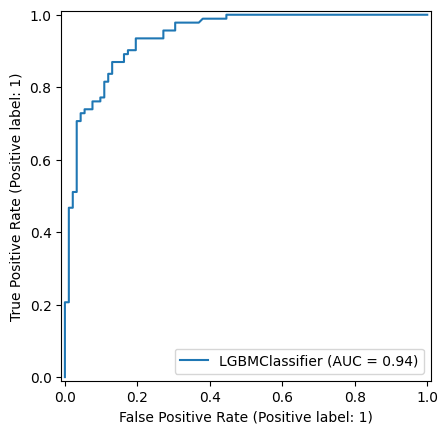

In [210]:
# Прогноз на X_test
gradient_boosting_LightGBM_model_metrics = get_metrics(model=gradient_boosting_LightGBM_model, y_pred=gradient_boosting_LightGBM_model.predict(X_test), y_test=y_test)
print(gradient_boosting_LightGBM_model_metrics)
df_sum_metrics_heart = pd.concat([df_sum_metrics_heart, pd.DataFrame([gradient_boosting_LightGBM_model_metrics])], ignore_index=True)


## Метрики Heart

In [226]:
df_sum_metrics_heart

,model,accuracy_score,recall_score,precision_score,roc_auc_score
0,"DecisionTreeClassifier(criterion='entropy', ma...",0.82,0.82,0.89,0.80
1,RandomForestClassifier(),0.85,0.85,0.93,0.83
2,<catboost.core.CatBoostClassifier object at 0x...,0.88,0.88,0.92,0.87
3,"LGBMClassifier(max_depth=2, n_estimators=70)",0.85,0.84,0.87,0.85
